In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, ConfusionMatrixDisplay, classification_report
from scipy.stats import ks_2samp
from operator import itemgetter

import lightgbm as lgbm

In [71]:
def split_data(df: pd.DataFrame, target: str, test_size: float, 
               val_size: float=None, random_state:int = 0):
    """
    returns (X_train, y_train, X_val, y_val, X_test, y_test)
    """
    if not val_size:
        val_size = test_size / (1 - test_size)

    train_val, test = train_test_split(df, test_size=test_size, stratify=df[target], random_state=random_state)
    train, val = train_test_split(train_val, test_size=val_size, stratify=train_val[target], random_state=random_state)

    X_train = train[train.columns.drop(target)]
    X_val = val[val.columns.drop(target)]
    X_test = test[test.columns.drop(target)]

    y_train = train[target]
    y_val = val[target]
    y_test = test[target]

    print(f'train shape: {X_train.shape}\nval shape: {X_val.shape}\ntest shape: {X_test.shape}')
    
    return X_train, y_train, X_val, y_val, X_test, y_test



def classification_predictive_power(y, pred, scoring_func=lambda x: x):
    """
    makes 4 plots:
    first two plots are PDF and CDF of probabilities or scores (if additional scoring/transformation function is provided)
    the third plot is a confusion matrix and the final plot is a classification report
    the function also calculates KS statistic, AUC and accuracy
    """
    title_font_size = 14
    table_cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.2, light=1,as_cmap=True)
    
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(2,2, figsize=(18,14))

    #PDF
    ks_data = pd.DataFrame({'Target': y, 'prob': pred})
    ks_data['SCORE'] = ks_data['prob'].apply(scoring_func)
    sns.histplot(data=ks_data, x='SCORE', hue='Target',  stat='probability', kde=True, bins=20, common_bins=False, 
                 common_norm=False, palette=['darkorange', 'grey'], ax=ax[0][0], edgecolor='black')
    ax[0][0].set_title('PDF', fontsize=title_font_size)

    #CDF
    sns.kdeplot(data=ks_data,x='SCORE', hue='Target', cumulative=True, common_norm=False, common_grid=True,
                palette=['darkorange', 'grey'], ax=ax[0][1])
    ax[0][1].set_title('CDF', fontsize=title_font_size)

    #confusion matrix
    ConfusionMatrixDisplay.from_predictions(y, pred > 0.5, ax=ax[1][0], cmap=table_cmap)
    ax[1][0].grid(None)
    ax[1][0].set_title('Confusion Matrix', fontsize=title_font_size)

    # classification report
    cr = pd.DataFrame(itemgetter('0','1')(classification_report(y, pred>.5, output_dict=True))).drop(columns = 'support')
    sns.heatmap(cr,annot=True,vmax=1,fmt='.5f',ax=ax[1][1],
                cmap=table_cmap)
    ax[1][1].set_title('Classification Report', fontsize=title_font_size)
    
    # KS, AUC, Accuracy
    fig.suptitle(f"""\
                 KS - {ks_2samp(ks_data.query('Target == 0')['SCORE'], ks_data.query('Target == 1')['SCORE'])[0]:.4f}\
                 AUC - {roc_auc_score(y, pred):.4f}\
                 Accuracy - {accuracy_score(y, pred>.5):.4f}""", y=.95, fontsize=16)
    plt.show()

In [101]:
df = pd.read_csv('heart.csv')
target = 'output'

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df, target=target, test_size=.2)

train shape: (181, 13)
val shape: (61, 13)
test shape: (61, 13)


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.393102


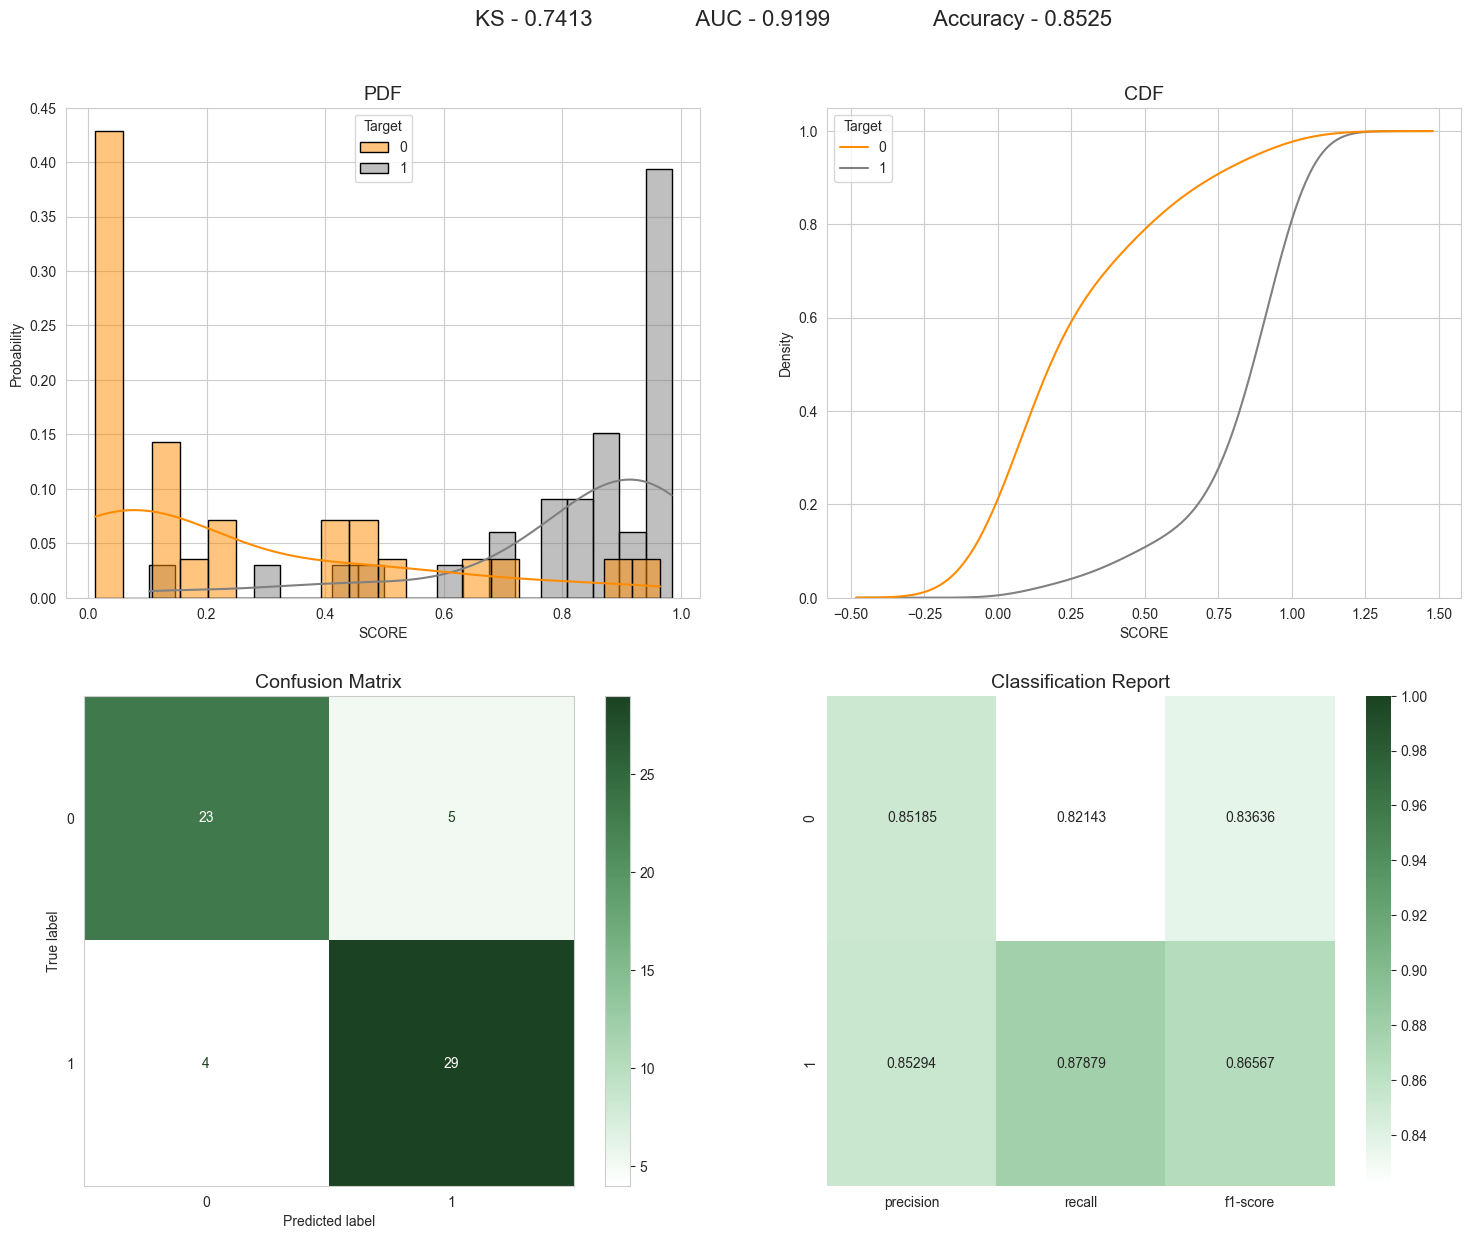

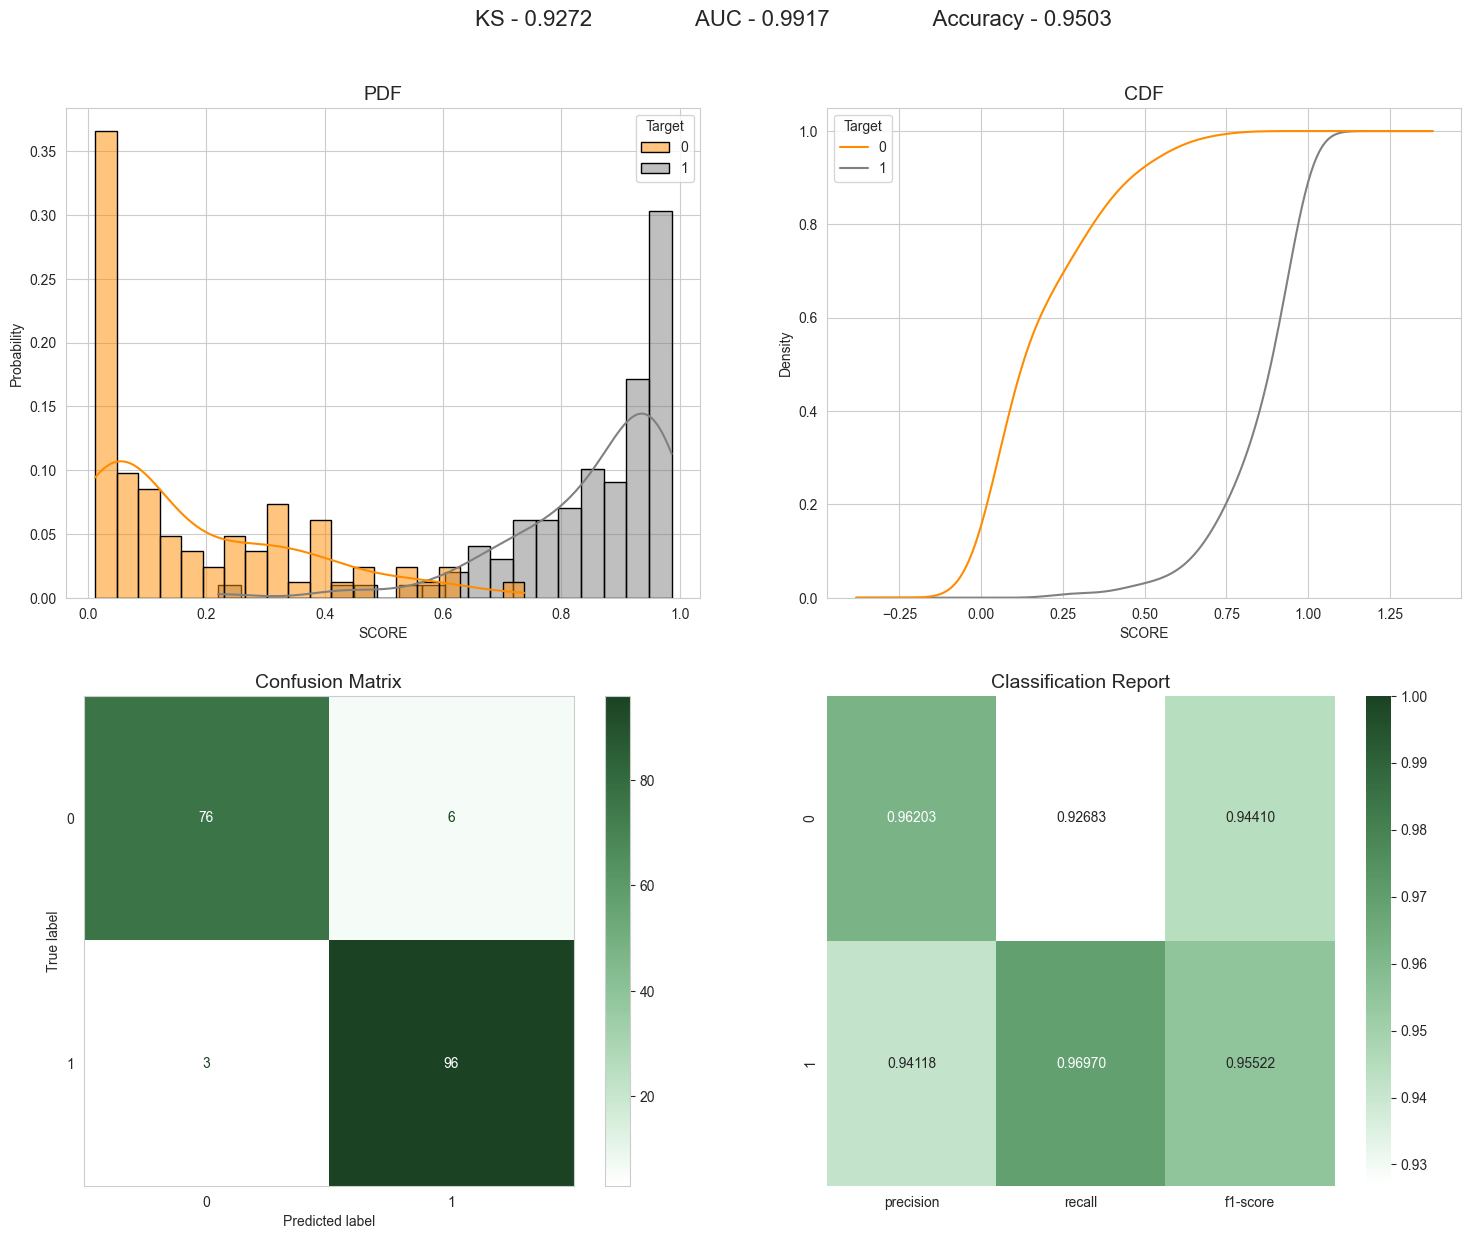

In [111]:
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'eval_metric': 'logloss',
    'n_estimators': 200,
    'verbose': -100
}

model = lgbm.LGBMClassifier(**params)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgbm.early_stopping(10)])

model.booster_.save_model('model.txt')
model = lgbm.Booster(model_file='model.txt')

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

classification_predictive_power(y_test, pred_test)

classification_predictive_power(y_train, pred_train)

In [2]:
df = pd.read_csv('data/heart.csv')
df = df[df.columns.drop('output')].iloc[:50]
df.to_csv('data/predict.csv', index=False)